## Homework 1

#### Import dependencies

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from category_encoders import OneHotEncoder 
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier 
import pickle

## Prepare Data

### Import

In [4]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    drop_off = pd.to_datetime(df.tpep_dropoff_datetime) 
    pick_up = pd.to_datetime(df.tpep_pickup_datetime)

    df["duration"] = drop_off - pick_up
    df.duration = df.duration.apply(lambda td: td.total_seconds()/ 60)

    mask = ((df.duration >= 1) & (df.duration <= 60))
    df_fil = df[mask]
    
    # Calculate the fraction of records left after dropping the outliers
    fraction_left = len(df_fil) / len(df) * 100
    print("Fraction of records left after dropping outliers:", fraction_left)
    
    
    return df_fil

In [5]:
df_train = read_dataframe(r"yellow_tripdata_2023-01.parquet")

Fraction of records left after dropping outliers: 98.1220282212598


Solution to question 3 : The Fraction of the records left after dropping outliers is 98%

In [6]:
df_val = read_dataframe(r"yellow_tripdata_2023-02.parquet")

Fraction of records left after dropping outliers: 98.00944077722545


### Explore

In [7]:
df_train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [8]:
# Check for the number of columns in the dataframe
df_train.shape

(3009173, 20)

Solution to question 1:
From the above dataframe there are 20 columns but note that a new column has been added by the read_dataframe function defined above. making the answer to the question 1 to be 19

In [9]:
# Check to confirm the datatype of the dataframe
df_train.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

In [10]:
# compute the descriptive statistics for the duration variable
df_train.duration.describe()

count    3.009173e+06
mean     1.420486e+01
std      9.939386e+00
min      1.000000e+00
25%      7.216667e+00
50%      1.155000e+01
75%      1.818333e+01
max      6.000000e+01
Name: duration, dtype: float64

Solution to question 2 : 
The standard deviation for the trip in January is 42.59 minutes.

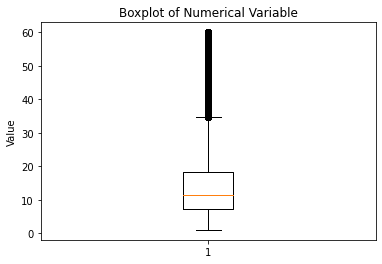

In [11]:
# Visualise the distribution of the duration variable
plt.boxplot(df_train['duration'])
plt.title('Boxplot of Numerical Variable')
plt.ylabel('Value')
plt.show()

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


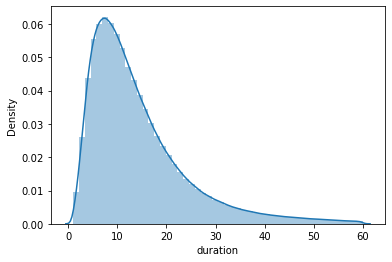

In [12]:
# visualize the distribution of the duartion variable
sns.distplot(df_train["duration"]);

## One-hot encoding of the categorical variables

In [24]:
# Apply one-hot encoding to the pickup and drop-off location id 
categorical = ["PULocationID", "DOLocationID"]

df_train[categorical] = df_train[categorical].astype(str)
df_val[categorical] = df_val[categorical].astype(str)

train_dicts = df_train[categorical].to_dict(orient='records')
val_dicts = df_val[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [14]:
X_train.shape

print("Dimensionality of the matrix:", X_train.shape[1])

Dimensionality of the matrix: 515


Solution to question 4:
Dimentionality of the matrix is 515.

## Train the model

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

train_rmse = mean_squared_error(y_train, y_pred, squared = False)

print('RMSE on train data:', train_rmse)

RMSE on train data: 7.6492610279057605


Solution to question 5 : 7.6492610279057605

### Visualize the result

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


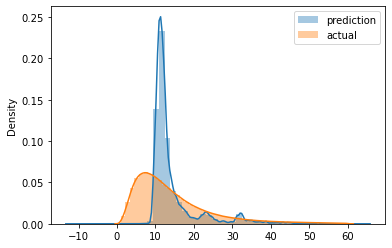

In [16]:
sns.distplot(y_pred, label = "prediction")
sns.distplot(y_train , label = "actual")
plt.legend();

In [25]:
val_pred = lr.predict(X_val)

val_rmse = mean_squared_error(y_val, val_pred, squared=False)

print('RMSE on validation data:', val_rmse)

RMSE on validation data: 7.81183265470218


Solution to question 6 : 7.81183265470218

## Save the file

In [21]:
with open("project1", 'wb') as f_out:
    pickle.dump((dv, lr), f_out)